In [1]:
%time
import torch
import gpytorch
import numpy as np
import pandas as pd
import itertools
import random
import pickle
import math
import cv2
import os
import re
from torch.nn.utils import clip_grad_norm_
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting toolkit
from numpy.linalg import inv

CPU times: total: 0 ns
Wall time: 0 ns


In [2]:
#Load data and prepare it for the GP
data = pd.read_csv('bf_sph_sound_0.csv')  

x_column = data['x_distance'].values
y_column = data['y_distance'].values
spl_column = data['sound_intensity'].values
direction = data['direction'].values #tan theta values

cos_values = np.cos(direction)
print(cos_values)
normalized_doa = np.array(cos_values)

min_numeric_value = np.nanmin(spl_column)
max_numeric_value = np.nanmax(spl_column[np.isfinite(spl_column)])

spl_column[np.isnan(spl_column)] = min_numeric_value 
spl_column[np.isinf(spl_column)] = max_numeric_value
mean_SIL_true = np.mean(spl_column, axis=0) #Normalise sound intensity values
std_SIL_true = np.std(spl_column, axis=0)
normalized_spl = (spl_column - mean_SIL_true) / std_SIL_true

survey_region = np.column_stack((x_column, y_column))

global_x_true = np.column_stack((x_column, y_column, normalized_doa))

intensity_loss_2d = normalized_spl.reshape(101, 101)
corner_coordinates = np.array([[-50.,-50.], [50.,50.], [-50.,50.], [50.,-50.]])

[ 0.70710678  0.70200152  0.69678568 ... -0.68231825 -0.6950221
 -0.70710678]


0.9999999999999997


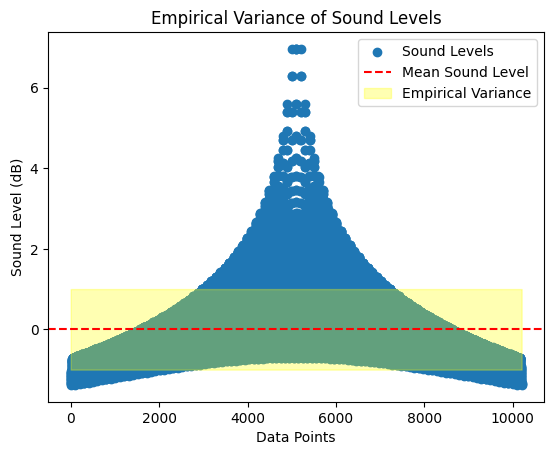

In [3]:
empirical_variance = np.var(normalized_spl)
print(empirical_variance)

# Plot the data and highlight the variance
plt.scatter(range(len(normalized_spl)), normalized_spl, label='Sound Levels')
plt.axhline(np.mean(normalized_spl), color='red', linestyle='--', label='Mean Sound Level')
plt.fill_between(range(len(normalized_spl)),
                 np.mean(normalized_spl) - np.sqrt(empirical_variance),
                 np.mean(normalized_spl) + np.sqrt(empirical_variance),
                 color='yellow', alpha=0.3, label='Empirical Variance')

# Customize the plot
plt.title('Empirical Variance of Sound Levels')
plt.xlabel('Data Points')
plt.ylabel('Sound Level (dB)')
plt.legend()
plt.show()

In [4]:
###Defining initial variables 
sampled_data = []
coordinates_passed = []
spl_sampled = []

sigma = 0.02

start_location = [48.0, 48.0] #define start location of the robot

n_samples = len(normalized_spl)
distance_horizon = 3  # Set your desired distance horizon
prediction_horizon = 3  # Set your desired prediction horizon
training_iter = 75  # Set your desired number of iterations
initial_sample_size = 8 # Set your desired initial training set size
convergence_criteria = False

# x_test_global = survey_region
local_survey_region = []

sample_iter = math.floor(n_samples/3)#int(200)
var_iter = []
var_iter_local = []
var_iter_global = []
rmse_local_true = []
rmse_global_true = []
#covar_global = []
covar_trace = []
covar_totelements = []
covar_nonzeroelements = []


noise = []
lengthscale = []

AIC = [] # Akaike Information Criterion
BIC = [] # Bayesian Information Criterion

f2_H_global = []
f2_H_local = []

image_path = 'D:\\UHM ORE\\Active Leanring\\scripts\\images\\'

x_max = [0., 0.] #Point with maximum global uncertainity
#Intialise Plot
fig = plt.figure(figsize=(24, 16))

<Figure size 2400x1600 with 0 Axes>

In [5]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims = 4))
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(ard_num_dims = 3, nu=0.5))
        #self.covar_module.base_kernel.lengthscale = length_scale
        self.rbf_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=3)  # Use 4 dimensions for (x, y, sin(angle), cos(angle))
        self.periodic_kernel = gpytorch.kernels.PeriodicKernel(ard_num_dims=3)
        self.covar_module = gpytorch.kernels.ProductKernel(self.rbf_kernel, self.periodic_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:
def kernel_print(i, training_iter, loss, model):
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.detach().numpy()[0][0],
            model.covar_module.base_kernel.lengthscale.detach().numpy()[0][1],
            model.likelihood.noise.detach().numpy()
        ))

In [7]:
def GPtrain(x_train, y_train, training_iter):
    x_train = [torch.tensor(arr, dtype=torch.float32) for arr in x_train]
    x_train = torch.stack(x_train)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(x_train, y_train, likelihood)
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()
    
    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # train GP model
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(x_train)
        # Calc loss and backprop gradients
        loss = -mll(output, y_train)
        loss.backward()
        kernel_print(i, training_iter, loss, model)
        optimizer.step()
    
    return likelihood, model, optimizer, output, loss

In [8]:
def GPEval(x_test, model, likelihood):
    x_test = [torch.tensor(arr, dtype=torch.float32) for arr in x_test]
    x_test = torch.stack(x_test)
    model.eval()
    likelihood.eval()
    
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(x_test))
        f_preds = model(x_test)
        f_mean = f_preds.mean
        f_var = f_preds.variance
        #f_var = np.diag(f_preds.lazy_covariance_matrix.numpy())
        f_covar = f_preds.covariance_matrix
    
    with torch.no_grad():
        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()

    # print('mean', f_mean)
    # print('var', f_var)
        
    return observed_pred, lower, upper, f_var, f_covar, f_mean

In [9]:
def SplDoaValue(x,y):
    index = np.where((x_column == x) & (y_column == y))[0]

    if index:
        corresponding_intensity = normalized_spl[index[0]]
        corresponding_angle = normalized_doa[index[0]]
        print(f"Sound intensity at ({x}, {y}): {corresponding_angle}")
    else:
        print(f"No data found for ({x}, {y})")
        corresponding_intensity = 0.0
        corresponding_angle = 0.0

    return corresponding_intensity, corresponding_angle

In [10]:
def CheckConvergence(rmse_global_true, convergence_criteria):
    # v = rmse_global_true
    # vo = np.max(rmse_global_true)
    # vfo = rmse_global_true[-1]

    # dv = vo-vfo
    # dv_2_percent = 0.02*dv

    # # Is there even enough data to confirm convergence?
    # v_95thresh = vo - 0.95*dv
    # i_95thresh = np.where(v < v_95thresh)
    # i_95thresh = np.array(i_95thresh[0], dtype=int)
    # if len(i_95thresh) >= 10:
    #     for i in range(len(i_95thresh)):
    #         v_con = v[i_95thresh[i]:-1]
    #         vf = np.mean(v_con)
    if (len(rmse_global_true)>20):
        errors_last20 = rmse_global_true[-20]
        mean_error = np.mean(errors_last20)
        if mean_error < 0.2:
            convergence_criteria = True
        else:
            convergence_criteria = False
    else:
        convergence_criteria = False

    return convergence_criteria

In [11]:
#x_true is all_points, #i_Sample is current coordinate, i_train = coordinates_passed
def plotGP():
    ax1 = fig.add_subplot(4, 3, 1, projection='3d')
    ax1.set_xlabel('X Coordinate')
    ax1.set_ylabel('Y Coordinate')
    ax1.set_zlabel('sound intensity')
    ax1.view_init(20, 20)
    ax1.set_title('asv on surface '+str(coordinates_passed[-1]))
    x_distances = np.arange(-50, 51, 1).astype(float)
    y_distances = np.arange(-50, 51, 1).astype(float)
    X, Y = np.meshgrid(x_distances, y_distances)
    ax1.plot_surface(X, Y, intensity_loss_2d, cmap='viridis', alpha=0.7)

    

    asv_path = ax1.plot3D([coord[0] for coord in coordinates_passed], [coord[1] for coord in coordinates_passed], spl_sampled, color='black')
    asv = ax1.scatter3D(coordinates_passed[-1][0], coordinates_passed[-1][1], 
                        spl_sampled[-1], s=100, color='black', marker='*', zorder=1)
    # # color by LAMP
    # surf = ax1.plot_trisurf(x_true[:, 0], x_true[:, 1], y_obs, cmap='inferno',
    #                         linewidth=0, alpha=0.25, vmax=max(y_obs), vmin=min(y_obs))
    points_pred = ax1.plot_trisurf(
         survey_region[:, 0], survey_region[:, 1], observed_pred_global.mean.numpy(), color='grey', alpha=0.25)
    # # Shade between the lower and upper confidence bounds
    for i_test in range(len(local_survey_region)):
        ax1.plot(local_survey_region[i_test][0]*np.array([1, 1]), local_survey_region[i_test][1]*np.array([1, 1]), 
                 np.array([lower_local[i_test].numpy(), upper_local[i_test].numpy()]), 'gray')

 
    #AX2 is diff
    ax2 = fig.add_subplot(4, 3, 2)
    ax2.set_xlim(-60,60)
    ax2.set_ylim(-60,60)
    ax2.set_xlabel('x coordinate')
    ax2.set_ylabel('y coordinate')
    ax2.set_title('asv on surface ' + str(coordinates_passed[-1]))
    contour = ax2.contourf(X, Y, intensity_loss_2d, cmap='viridis')
    cbar = fig.colorbar(contour)
    cbar.set_label('Sound Intensity')
    asv_path = ax2.plot([coord[0] for coord in coordinates_passed], [coord[1] for coord in coordinates_passed], color='pink')
    asv = ax2.scatter(coordinates_passed[-1][0], coordinates_passed[-1][1], color='pink', marker='*', label='ASV', s=100)
    ax2.scatter(x_max[0], x_max[1], color='red', label='global maximum uncertainity', s=50)



    ax3 = fig.add_subplot(4, 3, 3)
    ax3.plot(range(0, len(var_iter_local)),
             var_iter_local, color='blue', marker='.')
    ax3.plot(range(0, len(var_iter_global)),
             var_iter_global, color='black', marker='*')
    ax3.set_xlabel('number of samples')
    ax3.set_title('variance of samples')
    ax3.legend(['local', 'global'], loc='upper right')


    
    ax4 = fig.add_subplot(4, 3, 4)
    local_rms = ax4.plot(range(0, len(rmse_local_true)),
                         rmse_local_true, color='blue', marker='.', label='local')
    global_rms = ax4.plot(range(0, len(rmse_global_true)),
                          rmse_global_true, color='black', marker='*', label='global')
    ax4.set_xlabel('number of samples')
    ax4.legend(['local', 'global'], loc='upper right')
    ax4.set_title('rmse of learned model')
    
    ax5 = fig.add_subplot(4, 3, 5)
    ax6 = fig.add_subplot(4, 3, 6)

    lengthscale_arr = np.array(lengthscale)
    length0_plot = ax5.plot(range(0, len(lengthscale)),
                         lengthscale_arr[:,0], color='mediumpurple', marker='.', label='lengthscale')
    length1_plot = ax5.plot(range(0, len(lengthscale)),
                         lengthscale_arr[:,0], color='rebeccapurple', marker='.', label='lengthscale')
    ax5.set_ylim([0, np.max(lengthscale_arr)*1.1])
    noise_plot = ax6.plot(range(0, len(noise)),
                         noise, color='teal', marker='.', label='noise')
    ax5.set_xlabel('number of samples')
    ax5.set_ylabel('lengthscale',color='mediumpurple')
    ax6.set_ylabel('noise',color='teal')
    ax6.set_xlabel('number of samples')

    

    #Changing trace plot 
    
    ax7 = fig.add_subplot(4, 3, 7)
    tot_elements = ax7.plot(range(0, len(covar_totelements)),
                         covar_totelements, color='mediumvioletred', marker='.', label='total_elements')
    nonzero_elements = ax7.plot(range(0, len(covar_nonzeroelements)),
                         covar_nonzeroelements, color='blue', marker='.', label='nonzero_elements')
    ax7.set_ylabel('elements')
    ax7.set_xlabel('number of samples')
    ax7.legend(['total', 'nonzero'], loc='lower right')
    
    ax8 = fig.add_subplot(4, 3, 8)
    AIC_plot = ax8.plot(range(0, len(AIC)), AIC, color='blue', marker='.', label='AIC')
    BIC_plot = ax8.plot(range(0, len(BIC)), BIC, color='black', marker='*', label='BIC')
    ax8.set_xlabel('number of samples')
    ax8.legend(['AIC', 'BIC'], loc='lower right')
    ax8.set_ylabel('information criteria of learned model')
    
    ax9 = fig.add_subplot(4, 3, 9)
    RKHS_local_plot = ax9.plot(range(0, len(f2_H_local)), f2_H_local, color='blue', marker='.', label='f^2_H')
    RKHS_global_plot = ax9.plot(range(0, len(f2_H_global)), f2_H_global, color='black', marker='.', label='f^2_H')
    ax9.set_ylabel('RKHS_norm')
    ax9.set_xlabel('number of samples')
    ax8.legend(['local', 'global'], loc='lower right')

    ax10 = fig.add_subplot(4, 3, 10)
    trace = ax10.plot(range(0, len(covar_trace)),
                         covar_trace, color='pink', marker='.', label='trace')
    ax10.set_xlabel('number of samples')
    ax10.set_ylabel('trace',color='pink')

    x_grid_global = survey_region[:, 0]
    y_grid_global = survey_region[:, 1]
    x_grid_local = potential_sampling_locations[:, 0]
    y_grid_local = potential_sampling_locations[:, 1]
    # ax11 = fig.add_subplot(4, 3, 11)
    # ax12 = fig.add_subplot(4, 3, 12)
    # contour_global = ax11.scatter(x_grid_global, y_grid_global, c=MI_local, cmap='viridis')
    # contour_local = ax12.scatter(x_grid_global, y_grid_global, c=f_var_global, cmap='viridis')
    # cbar_global = fig.colorbar(contour_global)
    # cbar_global.set_label('Sampling Strategy Parameter')
    # cbar_local = fig.colorbar(contour_local)
    # cbar_local.set_label('Sampling Strategy Parameter')
    # ax11.set_xlabel('x coordinate global')
    # ax12.set_xlabel('x coordinate local')
    # ax11.set_ylabel('y coordinate global')
    # ax12.set_ylabel('y coordinate local')
    # ax11.set_title('Global MI Contour Map')
    # ax12.set_title('Global Varience Contour Map')

    return ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, 
# ax11, ax12

In [12]:
def PotentialNeighbors(current_coordinate, potential_neighbors, coordinates_passed):
    filtered = []
    # Traverse to a random nearest neighbor location
    for n in potential_neighbors:
        coordinate = current_coordinate+n
        arr_coord = coordinate
        #print(arr_coord)
        #print(coordinates_passed)
        
        if(~np.all(corner_coordinates == arr_coord, axis=1).any()):
            if (np.all(survey_region == arr_coord, axis=1).any()):
                if (~np.all(coordinates_passed == arr_coord, axis=1).any()):
                    filtered.append(coordinate.tolist())

    return filtered

In [13]:
#Reduction of entropy of target varience before and after observing inputs
def SamplingMuAndVar(var, mean, potential_neighbors):
    alpha = 1
    beta = 0
    sampling_mu_var = beta*mean+alpha*var
    sampling_mu_var_max = np.nanmax(sampling_mu_var.numpy())
    sampling_mu_var_max = np.where(sampling_mu_var.numpy() == sampling_mu_var_max)[0]
    next_sampling_location = potential_neighbors[sampling_mu_var_max,:]
    next_sampling_location = next_sampling_location[0]
    return next_sampling_location, sampling_mu_var


In [14]:
def RKHS_norm(y,sigma,K):
    n_row, n_col = K.shape
    alpha = inv(K + sigma**2 * np.eye(n_row)) @ y
    return alpha.transpose() @ K @ alpha

In [15]:
#Defining neighbors based on distance horizon
coordinates_range = range(-distance_horizon, distance_horizon)
potential_neighbors = np.array(list(itertools.product(coordinates_range, repeat=2)))

In [16]:
#Random walk for initial training
initial_training_set = []

# asv_start_location = torch.tensor(start_location, dtype=torch.float32)  # Start at center
asv_location = start_location
for _ in range(initial_sample_size):
    y, angle = SplDoaValue(asv_location[0], asv_location[1]) # Sample sound intensity at this location
    x = np.concatenate([asv_location, [angle]])
    spl_sampled.append(y)
    initial_training_set.append((x, y))
    coordinates_passed.append(asv_location)

    filtered_neighbors = PotentialNeighbors(asv_location, potential_neighbors, coordinates_passed)
    new_location = np.array(random.choice(filtered_neighbors))
    asv_location = new_location
    # print(new_location)
    #print(f"Moved to: {asv_location}")
# print(initial_training_set)

Sound intensity at (48.0, 48.0): -0.7071067811865475
Sound intensity at (49.0, 47.0): -0.7318939744313495
Sound intensity at (50.0, 47.0): -0.7432941462471664
Sound intensity at (49.0, 46.0): -0.7445694406464906
Sound intensity at (50.0, 44.0): -0.7808688094430304
Sound intensity at (47.0, 42.0): -0.7752349855172893
Sound intensity at (48.0, 40.0): -0.8137334712067352
Sound intensity at (48.0, 42.0): -0.7863183388224226


In [17]:
# Explore the surface
training_set = initial_training_set.copy()
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [18]:
while convergence_criteria is False:
    # Train Gaussian Process Model
    x_train, y_train = zip(*training_set)
    likelihood, model, optimizer, output, loss = GPtrain(x_train, y_train, training_iter)

    noise.append(model.likelihood.noise.detach().numpy())
    # lengthscale.append(model.covar_module.base_kernel.lengthscale.detach().numpy()[0])
    lengthscale.append(model.covar_module.base_kernel.lengthscale.detach().numpy()[0])

    model.eval()
    likelihood.eval()

    potential_sampling_locations = PotentialNeighbors(asv_location, potential_neighbors, coordinates_passed)
    potential_spls = [] #SIL is Sound INtensity Level
    potential_doas = []
    for i in potential_sampling_locations:
        potential_spl, potential_doa = SplDoaValue(i[0], i[1])
        potential_spls.append(potential_spl)
        potential_doas.append(potential_doa)

    local_x_true = np.column_stack([potential_sampling_locations, potential_doas])
    potential_sampling_locations = np.array(potential_sampling_locations)
    #Local
    observed_pred_local, lower_local, upper_local, f_var_local, f_covar_local, f_mean_local = GPEval(local_x_true, model, likelihood)
    mse_local_true = mean_squared_error(potential_spls, observed_pred_local.mean.numpy())
    rmse_local_true.append(math.sqrt(mse_local_true))

    #global
    observed_pred_global, lower_global, upper_global, f_var_global, f_covar_global, f_mean_global = GPEval(global_x_true, model, likelihood)
    mse_global_true = mean_squared_error(normalized_spl, observed_pred_global.mean.numpy())
    rmse_global_true.append(math.sqrt(mse_global_true))

    #Calculating Sampling Strategy Querries
    if var_iter_global:
        next_sampling_location, sampling_mu_var_g = SamplingMuAndVar(f_var_local, f_mean_local, potential_sampling_locations)

    else:
        local_var = f_var_local.numpy()
        highest_var = np.nanmax(local_var)
        index = np.where(local_var == highest_var)[0]
        next_sampling_location = potential_sampling_locations[int(index)]
        MI_local = f_var_global

        # distances = np.linalg.norm(asv_location - next_sampling_location)
        # closest_index = np.argmin(distances)
        # closest_point = next_sampling_location[closest_index]
        # next_sampling_location = closest_point

    print(next_sampling_location)
    var_iter_global.append(max(f_var_global.numpy()))
    var_iter_local.append(max(f_var_local.numpy()))

    #covar_global.append(f_covar_global)
    covar_trace.append(np.trace(f_covar_global.detach().numpy()))
    covar_totelements.append(np.size(f_covar_global.detach().numpy()))
    covar_nonzeroelements.append(np.count_nonzero(f_covar_global.detach().numpy()))
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # now evaluate information criteria
    # akaike information criterion
    AIC_sample = 2*np.log(covar_nonzeroelements[-1]) - 2*np.log(mse_global_true)
    AIC.append(AIC_sample)
    # BIC calculated from https://en.wikipedia.org/wiki/Bayesian_information_criterion#Gaussian_special_case
    BIC_sample = np.size(coordinates_passed)*np.log(covar_nonzeroelements[-1]) - 2*np.log(mse_global_true)
    BIC.append(BIC_sample)
    
    # and finally evaluate RKHS norm
    K_global = output._covar.detach().numpy()
    y_global = np.array(y_train)
    y_global = y_global.reshape(len(y_train),1)
    f2_H_sample = RKHS_norm(y_global,sigma,K_global)
    f2_H_global.append(f2_H_sample[0,0])
    
    n_set = len(initial_training_set)
    n_sub = math.floor(n_set/2)
    i_sub = random.sample(range(1,n_set),n_sub)
    i_sub.sort()
    K_local = K_global[np.ix_(i_sub,i_sub)]
    y_local = y_global[i_sub]
    f2_H_sample = RKHS_norm(y_local,sigma,K_local)
    f2_H_local.append(f2_H_sample[0,0])
    
    # plot real surface and the observed measurements
    ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10 = plotGP() #, ax11, ax12
    plt.show()

    fig.tight_layout()
    fig.savefig(image_path+str(len(training_set))+'.png')
    fig.clear()
    
    prev_var_pred_global = f_var_global
    prev_var_pred_local = f_var_local
    convergence_criteria = CheckConvergence(rmse_global_true, convergence_criteria)
    
    x_max = next_sampling_location
    asv_location = next_sampling_location
    print(asv_location)
    coordinates_passed.append(asv_location.tolist())

    new_spl, new_doa = SplDoaValue(asv_location[0], asv_location[1])
    spl_sampled.append(new_spl)
    sampled_data.append((new_location[0], new_location[1], new_doa, new_spl))
    new_input = np.concatenate([asv_location, [new_doa]])
    new_data_point = (new_input, new_spl)
    training_set.append(new_data_point)

AttributeError: 'ProductKernel' object has no attribute 'base_kernel'

In [ ]:
# %% convert images to video

video_name = 'asv_motion_model.avi'

images = []
int_list = []
for img in os.listdir(image_path):
    if img.endswith(".png"):
        images.append(img)
        s = re.findall(r'\d+', img)
        try:
            int_list.append(int(s[0]))
        except:
            print("whatever")

arg_list = np.argsort(int_list)

frame = cv2.imread(os.path.join(image_path, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(
    video_name, cv2.VideoWriter_fourcc(*'DIVX'), 30, (width, height))

for i in range(len(arg_list)):
    image = images[arg_list[i]]
    video.write(cv2.imread(os.path.join(image_path, image)))

cv2.destroyAllWindows()
video.release()

In [ ]:
class data:
    def __init__(self, sampled_data, i_train, var_iter_global, mse_global_true, 
                 rmse_global_true, mse_global_obs, rmse_global_obs, var_iter_local, 
                 mse_local_true, rmse_local_true, mse_local_obs, rmse_local_obs, covar_global, covar_trace, 
                 covar_totelements, covar_nonzeroelements, AIC, BIC, f2_H_local, f2_H_global):
        # likelihood, model, optimizer, output, loss,
        self.sampled_data = sampled_data
        # self.y_obs = y_obs
        self.i_train = i_train
        # self.likelihood = likelihood
        # self.model = model
        # self.optimizer = optimizer
        # self.output = output
        # self.loss = loss
        self.var_iter_global = var_iter_global
        self.mse_global_true = mse_global_true
        self.rmse_global_true = rmse_global_true
        self.mse_global_obs = mse_global_obs
        self.rmse_global_obs = rmse_global_obs
        self.var_iter_local = var_iter_local
        self.mse_local_true = mse_local_true
        self.rmse_local_true = rmse_local_true
        self.mse_local_obs = mse_local_obs
        self.rmse_local_obs = rmse_local_obs
        self.covar_global = covar_global
        self.covar_trace = covar_trace
        self.covar_totelements = covar_totelements
        self.covar_nonzeroelements = covar_nonzeroelements
        self.AIC = AIC
        self.BIC = BIC
        self.f2_H_local = f2_H_local
        self.f2_H_global = f2_H_global


mydata = data(sampled_data, training_set, var_iter_global, mse_global_true, rmse_global_true, mse_global_true, rmse_global_true,
              var_iter_local, mse_local_true, rmse_local_true, mse_local_true, rmse_local_true,
              f_covar_global, covar_trace, covar_totelements, covar_nonzeroelements, AIC, BIC, f2_H_local, f2_H_global)
#likelihood, model, optimizer, output, loss,
with open("data.p", "wb") as f:
    pickle.dump(mydata, f)

In [ ]:
# %% load data script
with open("data.p", "rb") as f:
    mydata = pickle.load(f)
sampled_data = mydata.sampled_data
# y_obs = mydata.y_obs
i_train = mydata.i_train
# likelihood = mydata.likelihood
# model = mydata.model
# optimizer = mydata.optimizer
# output = mydata.output
# loss = mydata.loss
var_iter_global = mydata.var_iter_global
mse_global_true = mydata.mse_global_true
rmse_global_true = mydata.rmse_global_true
mse_global_obs = mydata.mse_global_obs
rmse_global_obs = mydata.rmse_global_obs
var_iter_local = mydata.var_iter_local
mse_local_true = mydata.mse_local_true
rmse_local_true = mydata.rmse_local_true
mse_local_obs = mydata.mse_local_obs
rmse_local_obs = mydata.rmse_local_obs
# x_test_local = mydata.x_test_local
# x_test_global = mydata.x_test_global
covar_global = mydata.covar_global
covar_trace = mydata.covar_trace
covar_totelements = mydata.covar_totelements
covar_nonzeroelements = mydata.covar_nonzeroelements
AIC = mydata.AIC
BIC = mydata.BIC
f2_H_local = mydata.f2_H_local
f2_H_global = mydata.f2_H_global

In [ ]:
print(rmse_global_true[-1])

In [ ]:
def CheckConvergence():
    v = rmse_global_true
    vo = np.max(rmse_global_true)
    vfo = rmse_global_true[-1]

    dv = vo-vfo
    dv_2percent = 0.02*dv

    print(dv_2percent)
    # Is there even enough data to confirm convergence?
    v_95thresh = vo - 0.95*dv
    i_95thresh = np.where(v < v_95thresh)
    i_95thresh = np.array(i_95thresh[0], dtype=int)
    if len(i_95thresh) >= 10:
        for i in range(len(i_95thresh)):
            v_con = v[i_95thresh[i]:-1]
            vf = np.mean(v_con)
            if np.all(v_con <= vf+dv_2percent) and np.all(v_con >= vf-dv_2percent):
                print("convergence roving distance is " +
                    str(asv_distance[i_95thresh[i]]))
                print("total samples is "+str(len(asv_distance))+" where the convergence index is " +
                    str(i_95thresh[i]))
                print("convergence true rms error is " +
                    str(rmse_global_true[i_95thresh[i]]))
                print("convergence observed rms error is " +
                    str(rmse_global_obs[i_95thresh[i]]))
                print("reduction of error is " +
                    str(max(rmse_global_true)/rmse_global_true[i_95thresh[i]]))
                # plotty plot plot converge wrt rms error and distance!
                fig = plt.figure(figsize=(12, 6))
                ax1 = fig.add_subplot(1, 2, 1)
                local_rms = ax1.plot(range(0, len(
                    rmse_local_true)), rmse_local_true, color='blue', marker='.', label='local')
                global_rms = ax1.plot(range(0, len(
                    rmse_global_true)), rmse_global_true, color='black', marker='*', label='global')
                ax1.plot([0, len(var_iter_global)], np.array(
                    [1, 1])*(vf+dv_2percent), 'r--')
                ax1.plot([0, len(var_iter_global)], np.array(
                    [1, 1])*(vf-dv_2percent), 'r--')
                ax1.plot(i_95thresh[i]*np.array([1, 1]), [0, vo], 'r--')
                ax1.set_xlabel('number of samples')
                ax1.set_ylabel('rmse')
                ax1.legend(['local', 'global', 'convergence bounds'],
                        loc='upper right')
                ax1.set_title('rmse of learned model')
                ax2 = fig.add_subplot(1, 2, 2)
                ax2.plot(range(len(asv_distance)), asv_distance, 'k*-')
                ax2.plot(i_95thresh[i]*np.array([1, 1]),
                        [0, max(asv_distance)], 'r--')
                ax2.plot([0, len(asv_distance)],
                        asv_distance[i_95thresh[i]]*np.array([1, 1]), 'r--')
                ax2.set_xlabel('number of samples')
                ax2.set_ylabel('roving distance')
                ax2.set_title('asv distance during exploration')
                plt.show()
                fig.tight_layout()
                fig.savefig(image_path+'convergence.png')
                break
    else:
        print("not able to evaluate convergence")
        print("reduction of true error is " +
            str(max(rmse_global_true)/rmse_global_true[-1]))
        print("reduction of observed error is " +
            str(max(rmse_global_obs)/rmse_global_obs[-1]))

0.027673869453627438
convergence roving distance is 3888.0
total samples is 389 where the convergence index is 338
convergence true rms error is 0.2306647256088017
convergence observed rms error is 0.2306647256088017
reduction of error is 6.844369729735271


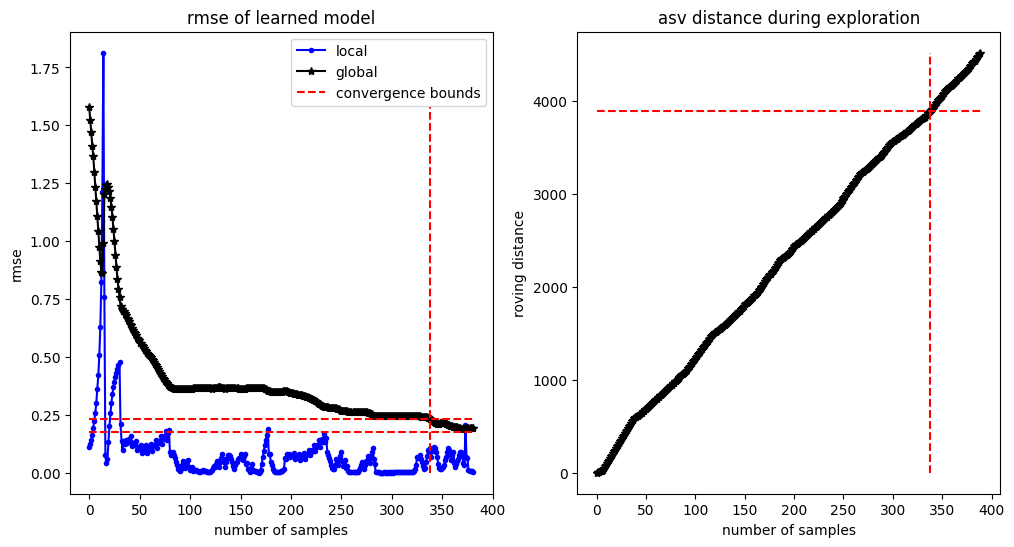

In [ ]:
CheckConvergence()

In [ ]:
%time

CPU times: total: 0 ns
Wall time: 0 ns
